# Time series preprocessing

Time series refers to data collected over time. It is a sequence of samples that were measured during some period of time, in some given intervals.

In [1]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
#import seaborn as sns

%matplotlib inline

plt.rcParams['figure.figsize'] = (20.0, 10.0)

We shall start with a famous data set: the number of international passengers per month on Pan Am airline in the US obtained from the Fedral Aviation Administration for the period 1946-1960.

In [2]:
data = pd.read_csv('AirPassengers.csv')

In [3]:
print(data.head())
print('\n')
print(data.info())

     Month  #Passengers
0  1949-01          112
1  1949-02          118
2  1949-03          132
3  1949-04          129
4  1949-05          121


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
Month          144 non-null object
#Passengers    144 non-null int64
dtypes: int64(1), object(1)
memory usage: 2.3+ KB
None


Let's plot the data first.

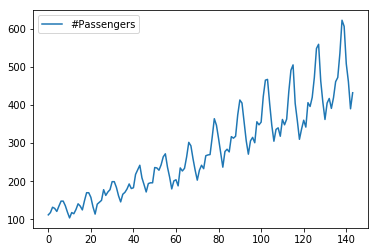

In [4]:
data.plot()

Pandas has support for time series - see https://pandas.pydata.org/pandas-docs/stable/timeseries.html
We shall start by making the index a time data format.

In [5]:
data.index

RangeIndex(start=0, stop=144, step=1)

https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html

Instead of converting the index, we can specify in when reading the csv.

In [6]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m') #we need to parse the given time format
data = pd.read_csv('AirPassengers.csv', parse_dates=['Month'], index_col='Month',date_parser=dateparse)
print(data.head())

            #Passengers
Month                  
1949-01-01          112
1949-02-01          118
1949-03-01          132
1949-04-01          129
1949-05-01          121


In [7]:
data.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

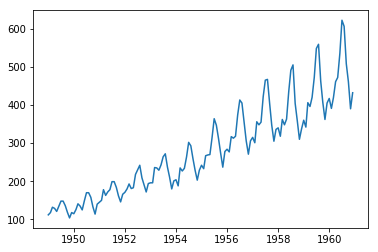

In [8]:
plt.plot(data) #this shows the labels of x-axis correctly only sometimes

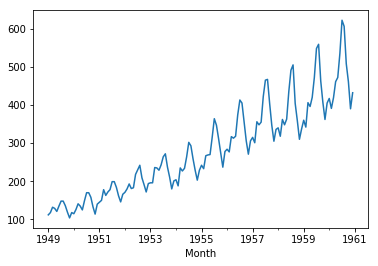

In [9]:
series = data['#Passengers']
series.plot() #this shows the x-axis ok (once done, the previous method starts to work properly?)

In [10]:
series['1960-12-01']

432

In [11]:
# indices need to be sorted in order for the range indexing to work properly:
series['1949-01-01':'1949-05-01']

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
Name: #Passengers, dtype: int64

Month
1960-12-01    432
1960-11-01    390
1960-10-01    461
1960-09-01    508
1960-08-01    606
Name: #Passengers, dtype: int64

Test range indexing:
Series([], Name: #Passengers, dtype: int64)


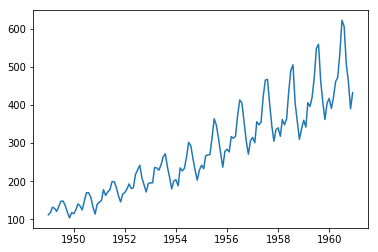

In [12]:
series2 = series.sort_index(ascending=False)
print(series2.head())
print('\nTest range indexing:')
print(series2['1949-01-01':'1949-05-01'])
plt.plot(series2)

In [13]:
from datetime import datetime
series[datetime(1955,1,1)]

242

## General concepts for time series preprocessing

First step is to clear the data:

* Remove noise
* Remove/correct offsets
* Remove trends
* Normalize/Standardize the data (?)

How can it be achieved?





















Suma kvadrátů reziduí ACF: 1.5329883864684195


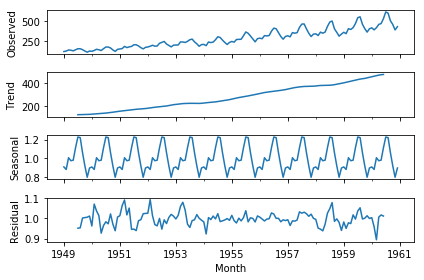

In [14]:
# plouvouci vokno vyhlazovani
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf

result = seasonal_decompose(data, freq=12, model='multiplikative')
resid_acf = acf(result.resid, nlags=10, missing='drop')
sum_of_squares_resid_acf = np.sum(resid_acf**2)
print('Suma kvadrátů reziduí ACF:', sum_of_squares_resid_acf)

result.plot()
plt.show()

## Rolling window / convolution

One of the basic tools is to investigate statistic properties calculated over a (weighted) window = an interval of given length which moves over the time index of the series.

https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.rolling.html

In [15]:
q = series.rolling(15, min_periods=None, center=False, win_type='boxcar', on=None, axis=0, closed=None)
# window types - see https://docs.scipy.org/doc/scipy/reference/signal.html#window-functions

In [16]:
#q.mean()

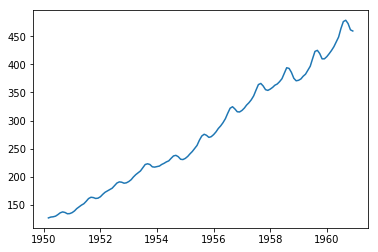

In [17]:
plt.plot(q.mean())

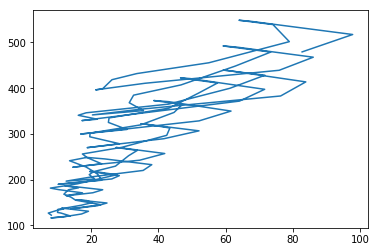

In [18]:
q = series.rolling(5, center=False)
plt.plot(q.std(),q.mean()) #an artistic intermezzo

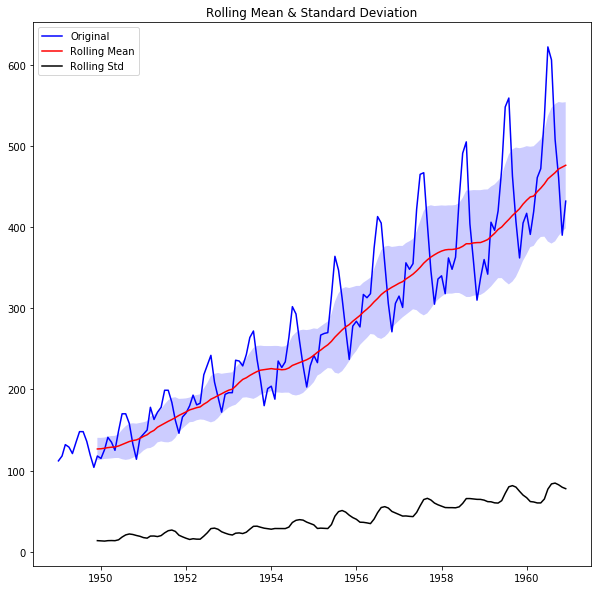

In [19]:
N = 12
q = series.rolling(N)
rolmean = q.mean()
rolstd = q.std()

plt.figure(figsize=(10,10))
orig = plt.plot(series, color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
#plt.fill_between(rolmean.index, rolmean-rolstd, rolmean+rolstd)
plt.fill_between([item.strftime('%Y-%m-%d') for item in series.index], list(rolmean-rolstd), list(rolmean+rolstd),facecolor='blue', alpha=.2)
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

This time series does not contain any noise - we have integer data assumed to be correct.
There is an obvious increasing trend.
We shall try **removing the trend**.

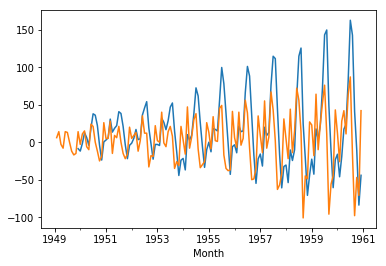

In [20]:
# TASK 1 - remove the trend in `series` and plot the result

(series - rolmean).plot()
series.diff(1).plot()

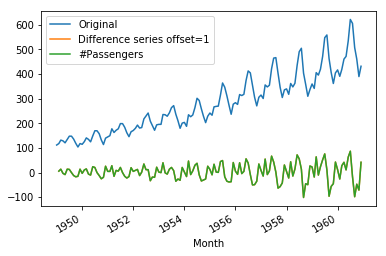

In [21]:
# we shall deal with the trend using another (very simple) method (however, the data are transformed substantially)

# create a differenced series
def difference(dataset, offset=1):
    diff = list()
    for i in range(offset, len(dataset)):
        value = dataset[i] - dataset[i - offset]
        diff.append(value)
    return diff
 
# define a dataset with a linear trend
plt.plot(series,label='Original')
# difference the dataset
offset = 1
diff = difference(data.values, offset)
plt.plot(series.index[offset:],diff,label='Difference series offset='+str(offset))
series.diff(1).plot()
plt.legend(loc='best')
plt.show()

In [22]:
#we store the series without trend
series_without_trend = (series-series.shift(1,freq='MS')).dropna() #replace by your solution, this is not exactly the series without trend

### Standardization

Standardization refers (again) to the procedure of shifting and rescaling the series such that it has zero mean and variance $1$.

It makes little sense to normalize a series that contains a trend.

Mean: 280.298611, StandardDeviation: 119.549042
Mean: 2.237762, StandardDeviation: 33.636053


/home/ladislav/MI-PDD2018/MI-PDD-2018-martilad/06/__venv__/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/ladislav/MI-PDD2018/MI-PDD-2018-martilad/06/__venv__/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


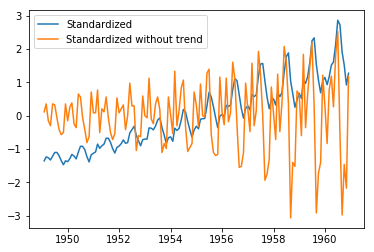

In [23]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

values = series.values
values = values.reshape((len(values), 1))
# train the standardization
scaler = StandardScaler()
scaler = scaler.fit(values)
print('Mean: %f, StandardDeviation: %f' % (scaler.mean_, np.sqrt(scaler.var_)))
# standardization the dataset and print the first 5 rows
normalized = scaler.transform(values)


values = series_without_trend.values
values = values.reshape((len(values), 1))
scaler = scaler.fit(values)
print('Mean: %f, StandardDeviation: %f' % (scaler.mean_, np.sqrt(scaler.var_)))
normalized_series_without_trend = scaler.transform(values)


#plt.plot(series, color='blue',label='Original')
plt.plot(series.index[offset:],normalized[offset:],label='Standardized')
plt.plot(series.index[offset:],normalized_series_without_trend,label='Standardized without trend')
plt.legend(loc='best')


Differences can also be done using pandas `shift`.
The method can also work with a time index.

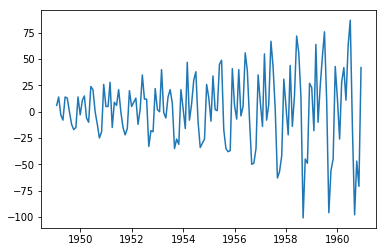

In [24]:
plt.plot(series-series.shift(offset))

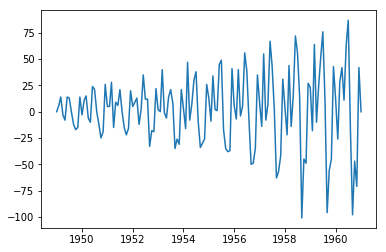

In [25]:
plt.plot( (series-series.shift(offset,freq='MS')).fillna(0) )

### Noise reduction

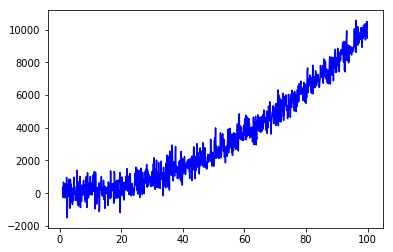

In [26]:
#Generate some data with noise

mu, sigma = 0, 500

x = np.arange(1, 100, 0.1)  # x axis
z = np.random.normal(mu, sigma, len(x))  # noise
y = x ** 2 + z # data
plt.plot(x, y, linestyle="-", c="b")  # it include some noise

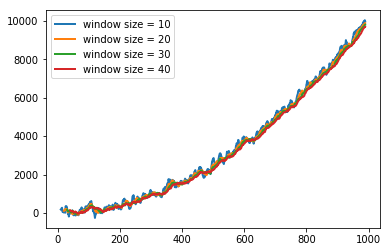

In [27]:
Y = pd.Series(y)
for window_size in [10,20,30,40]:
    plt.plot(Y.rolling(window_size).mean(),linewidth=2,label='window size = %s' % window_size)
plt.legend()

### _Seasonal decomposition_

Seasonal decomposition is a decomposition of times series using one of the two common models:

_additive_: Trend + Seasonality + Noise

_multiplicative_: Trend \* Seasonality \* Noise

We shall only quickly test a naive implementation http://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.seasonal_decompose.html

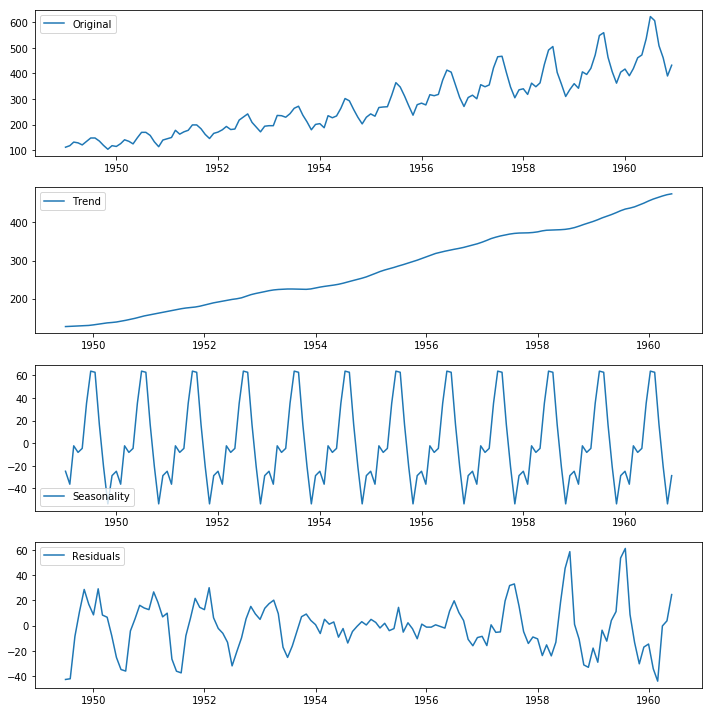

In [28]:
# only easy MA filter -> it is good use for look on data only :)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(series, model='additive')

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(10,10))
plt.subplot(411)
plt.plot(series, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

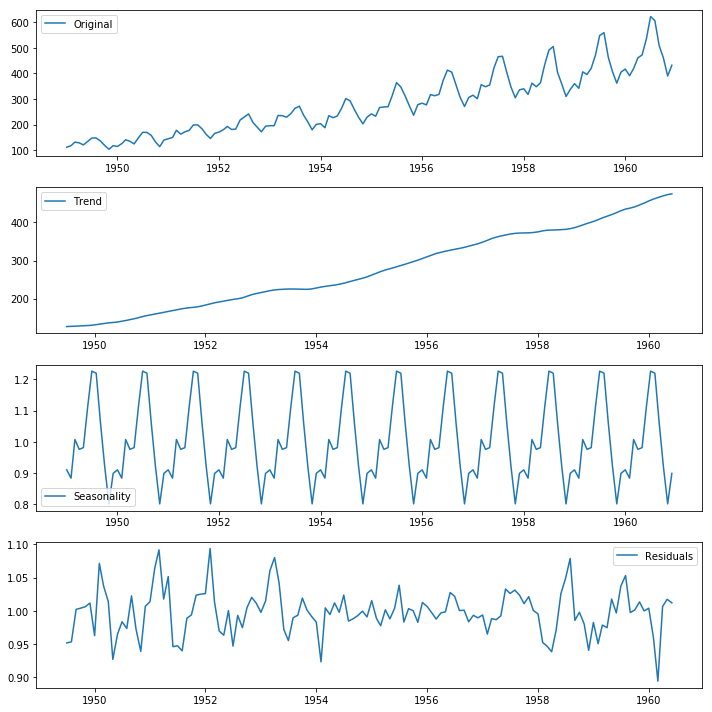

In [29]:
decomposition = seasonal_decompose(series, model='multiplicative')

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(10,10))
plt.subplot(411)
plt.plot(series, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

More advanced techniques are available, the starting points are the keywords [Digital signal processing](https://en.wikipedia.org/wiki/Digital_signal_processing) and [Digital filter](https://en.wikipedia.org/wiki/Digital_filter).

## Time series similarity

For the two basic tasks of machine learning, prediction and classification, we have (very quickly) covered the preprocessing for prediction. For the classification task, we need to be able to tell how much are two time series similar one to another.

We start by generating a simple artificial example.

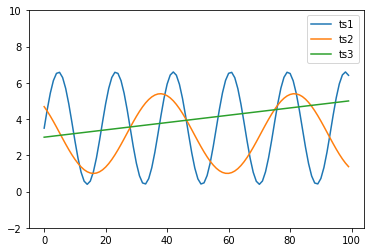

In [30]:
x=np.linspace(0,50,100)
ts1=pd.Series(3.1*np.sin(x/1.5)+3.5)
ts2=pd.Series(2.2*np.sin(x/3.5+2.4)+3.2)
ts3=pd.Series(0.04*x+3.0)

ts1.plot()
ts2.plot()
ts3.plot()

plt.ylim(-2,10)
plt.legend(['ts1','ts2','ts3'])
plt.show()

Is `ts1` more similar to `ts2` or to `ts3`?

In [31]:
print(np.linalg.norm(ts1-ts2))
print(np.linalg.norm(ts1-ts3))

26.95921603796934
23.18924919031106


If we use the Euclidean norm, the answer is in contradiction with our intuition.

In general, Euclidean norm is not very useful and makes little sense, although it may be enough sometimes:

In [32]:
offset = 1
diff = series-series.shift(offset,freq='MS')
diff = diff.dropna()
total = diff.shape[0]

for N in range(1,30):
    diff1 = np.array(diff[N:].values)
    diff2 = np.array(diff[:-N].values)
    print('N=%d norm=%f' % (N,np.linalg.norm(diff1-diff2)/(np.sqrt(total-N)))) #the denominator is a normalizing term - the compared vectors have distinct dimension

N=1 norm=39.715892
N=2 norm=49.788987
N=3 norm=52.921573
N=4 norm=53.716348
N=5 norm=49.184877
N=6 norm=48.441778
N=7 norm=48.680531
N=8 norm=53.577013
N=9 norm=51.269700
N=10 norm=49.292971
N=11 norm=38.605326
N=12 norm=12.310859
N=13 norm=38.666225
N=14 norm=49.668826
N=15 norm=52.473207
N=16 norm=52.160715
N=17 norm=48.005043
N=18 norm=47.819327
N=19 norm=48.459328
N=20 norm=53.904462
N=21 norm=50.653678
N=22 norm=48.358168
N=23 norm=37.909322
N=24 norm=15.294861
N=25 norm=38.057494
N=26 norm=49.142302
N=27 norm=51.836198
N=28 norm=50.548384
N=29 norm=47.738230


We detect a periodic behaviour in the seasonality of `series`, and the period is 12 months!

### A short detour - Discrete Fourier Transform & friends

The Discrete Fourier Transform, and similar transform, are an important tool in digital signal processing.

In short, they transform the series, seen as a vector, to another basis, that is, they return the coordinates of the series vector in a suitable (orthonormal) basis.

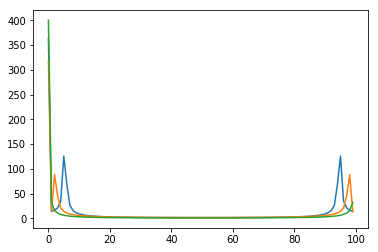

In [33]:
fft_ts1 = np.fft.fft(ts1)
fft_ts2 = np.fft.fft(ts2)
fft_ts3 = np.fft.fft(ts3)

#print(fft_ts1)
plt.plot(np.abs(fft_ts1))
plt.plot(np.abs(fft_ts2))
plt.plot(np.abs(fft_ts3))

Using Euclidean distance will yield the same result (this is Parseval's theorem).

(There is a factor since the default implementaion is not normalizing the results of DFT/FFT.)

In [34]:
print(np.linalg.norm((fft_ts1-fft_ts2)))
print(np.linalg.norm((fft_ts1-fft_ts3)))

269.59216037969344
231.89249190311057


However, DFT might be used to reduce the dimension of the vectors; only the first few coefficients are taken into account as they usually are the most important for the signal.

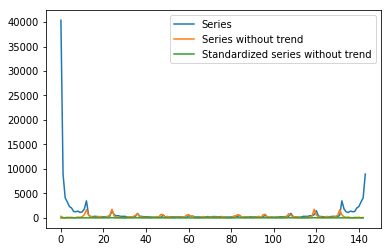

In [35]:
plt.plot(np.abs(np.fft.fft(np.array(series.values))),label='Series')
plt.plot(np.abs(np.fft.fft(np.array(series_without_trend))),label='Series without trend')
plt.plot(np.abs(np.fft.fft(normalized_series_without_trend,axis=0)),label='Standardized series without trend') #axis=0 is *very* importnant since `normalized_diff` has wrong shape
plt.legend()

### Dynamic time warping

Dynamic time warping finds the optimal non-linear alignment between two time series. The aligment on the time axis fixes the distortions that cannot be captured when comparing coefficients having the same index (as many metrics do). Dynamic time warping is _quadratic_ in the length of the time series used.

Dynamic time warping works in the following way. Consider two time series $Q$ and $C$ of the same length $n$ where $$Q=q_1,q_2,...,q_n$$ and $$C=c_1,c_2,...,c_n.$$
We construct an $n\times n$ matrix $M$ whose $i,j^{th}$ element is the (Euclidean) distance between $q_i$ and $c_j$.
We want to find a path through this matrix that minimizes the cumulative distance.
This path then determines the optimal alignment between the two time series.
Of course, we restrict ourselves to path that have non-decreasing indices and have fixed starting end ending points.

The optimal path is usually found via dynamic programming, specifically the following recursive function:$$\gamma(i,j)=\mathrm{d}(q_i,c_j)+\min ( \gamma(i-1,j-1),\gamma(i-1,j),\gamma(i,j-1)),$$ 
where $\mathrm{d}$ is some distance.

In [36]:
# taken from https://github.com/alexminnaar/time-series-classification-and-clustering
def DTWDistance(s1, s2):
    DTW={}
    
    for i in range(len(s1)):
        DTW[(i, -1)] = float('inf')
    for i in range(len(s2)):
        DTW[(-1, i)] = float('inf')
    DTW[(-1, -1)] = 0

    for i in range(len(s1)):
        for j in range(len(s2)):
            dist= (s1[i]-s2[j])**2
            DTW[(i, j)] = dist + min(DTW[(i-1, j)],DTW[(i, j-1)], DTW[(i-1, j-1)])

    return np.sqrt(DTW[len(s1)-1, len(s2)-1])

In [37]:
print(DTWDistance(ts1,ts2))
print(DTWDistance(ts1,ts3))

17.929718468641138
21.549494824404572


We can improve the DTW distance by adding another restriction for the path: we require the path to be close the diagonal of $M$. The closeness is given by the width `w` of the stripe along the diagonal that is to contain the optimal path. In other words, we give a limit on the maximal possible time distortion that DTW can capture.

In [38]:
def DTWDistance(s1, s2, w):
    DTW={}
    
    w = max(w, abs(len(s1)-len(s2)))
    
    for i in range(-1,len(s1)):
        for j in range(-1,len(s2)):
            DTW[(i, j)] = float('inf')
    DTW[(-1, -1)] = 0
  
    for i in range(len(s1)):
        for j in range(max(0, i-w), min(len(s2), i+w)):
            dist= (s1[i]-s2[j])**2
            DTW[(i, j)] = dist + min(DTW[(i-1, j)],DTW[(i, j-1)], DTW[(i-1, j-1)])

    return np.sqrt(DTW[len(s1)-1, len(s2)-1])

In [39]:
print(DTWDistance(ts1,ts2,10))
print(DTWDistance(ts1,ts3,10))

18.59655183841726
22.47248284679103


In [40]:
for N in range(1,15):
    diff1 = np.array(series_without_trend[N:].values)
    diff2 = np.array(series_without_trend[:-N].values)
    print('N=%d DTW=%f' % (N,DTWDistance(diff1,diff2,10)))

N=1 DTW=113.282832
N=2 DTW=94.164749
N=3 DTW=153.508957
N=4 DTW=120.735248
N=5 DTW=147.827602
N=6 DTW=141.456707
N=7 DTW=144.034718
N=8 DTW=141.820309
N=9 DTW=139.942845
N=10 DTW=148.330712
N=11 DTW=131.582674
N=12 DTW=127.863208
N=13 DTW=153.368836
N=14 DTW=161.304061


Another similarity measure requires to build an envolepe around the base series and then test whether the tested signal falls well into this envelope.

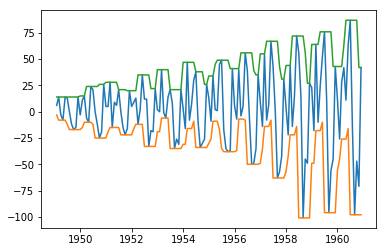

In [41]:
#envelope

r = 3
L = [min(series_without_trend[(ind-r if ind-r>=0 else 0):(ind+r)]) for ind in range(len(series_without_trend))] #lower bound for the envelope
U = [max(series_without_trend[(ind-r if ind-r>=0 else 0):(ind+r)]) for ind in range(len(series_without_trend))] #upper bound for the envelope

plt.plot(series_without_trend)
plt.plot(series_without_trend.index,L)
plt.plot(series_without_trend.index,U)

We load a more suitable data to test this approach.

In [42]:
# last column always contains the class!
train = np.genfromtxt('train.csv', delimiter='\t')
test = np.genfromtxt('test.csv', delimiter='\t')

train

array([[-0.37693558,  1.2248643 ,  0.34387438, ..., -1.3117417 ,
        -1.1971462 ,  1.        ],
       [ 0.64440621,  0.41326914, -0.86227849, ...,  0.08574208,
         0.02499741,  1.        ],
       [-0.97866735, -0.40623244,  0.82242857, ...,  0.10699555,
         0.08271546,  1.        ],
       ...,
       [ 0.96590061,  0.64016083,  0.48085702, ..., -1.195676  ,
        -0.80364439,  6.        ],
       [ 0.35497067,  0.10965181,  0.23889694, ..., -1.7653707 ,
        -1.6753831 ,  6.        ],
       [ 0.64661651,  0.61351555,  1.1266638 , ..., -0.83334659,
        -0.26117832,  6.        ]])

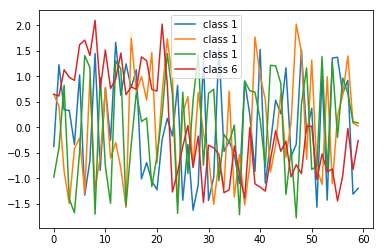

In [43]:
#plt.figure(figsize=(10,10))
plt.plot(train[0,:-1],label='class %d' % train[0,-1])
plt.plot(train[1,:-1],label='class %d' % train[1,-1])
plt.plot(train[2,:-1],label='class %d' % train[2,-1])

plt.plot(train[-1,:-1],label='class %d' % train[-1,-1])

plt.legend()

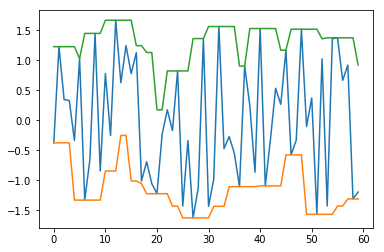

In [44]:
ts = train[0,:-1]
r = 3
L = [min(ts[(ind-r if ind-r>=0 else 0):(ind+r)]) for ind in range(len(ts))]
U = [max(ts[(ind-r if ind-r>=0 else 0):(ind+r)]) for ind in range(len(ts))]

plt.plot(ts)
plt.plot(L)
plt.plot(U)

The distance from the envelope is given by the following the _LB Keogh_ lower bound of dynamic time warping.
It is defined as $$LBKeogh(Q,C)=\sum_{i=1}^n (c_i-U_i)^2I(c_i > U_i)+(c_i-L_i)^2I(c_i < L_i)$$
where $U_i$ and $L_i$ are upper and lower bounds for time series $Q$ which are defined as $U_i=max(q_{i-r}:q_{i+r})$ and $L_i=min(q_{i-r}:q_{i+r})$ for a reach $r$ and $I(\cdot)$ is the indicator function.

Its name comes from the fact that it was originally conceived as a cheaper indicator for the DTW metric, having this property:
$$LB Keogh(Q,C) \leq DTW(Q,C)$$

In [45]:
def LB_Keogh(s1,s2,r):
    LB_sum=0
    for ind,i in enumerate(s1):
        
        lower_bound=min(s2[(ind-r if ind-r>=0 else 0):(ind+r)])
        upper_bound=max(s2[(ind-r if ind-r>=0 else 0):(ind+r)])
        
        if i>upper_bound:
            LB_sum=LB_sum+(i-upper_bound)**2
        elif i<lower_bound:
            LB_sum=LB_sum+(i-lower_bound)**2
    
    return np.sqrt(LB_sum)

In [46]:
print(LB_Keogh(train[0,:-1],ts,5))
print(LB_Keogh(train[1,:-1],ts,5))
print(LB_Keogh(train[2,:-1],ts,5))
print(LB_Keogh(train[-1,:-1],ts,5))

0.0
1.3163875046068647
1.3391804641274128
1.0944124674000166


In [47]:
print(DTWDistance(train[0,:-1],ts,5))
print(DTWDistance(train[1,:-1],ts,5))
print(DTWDistance(train[2,:-1],ts,5))
print(DTWDistance(train[-1,:-1],ts,5))

0.0
5.009907372383207
5.204767709613196
6.891864794154797


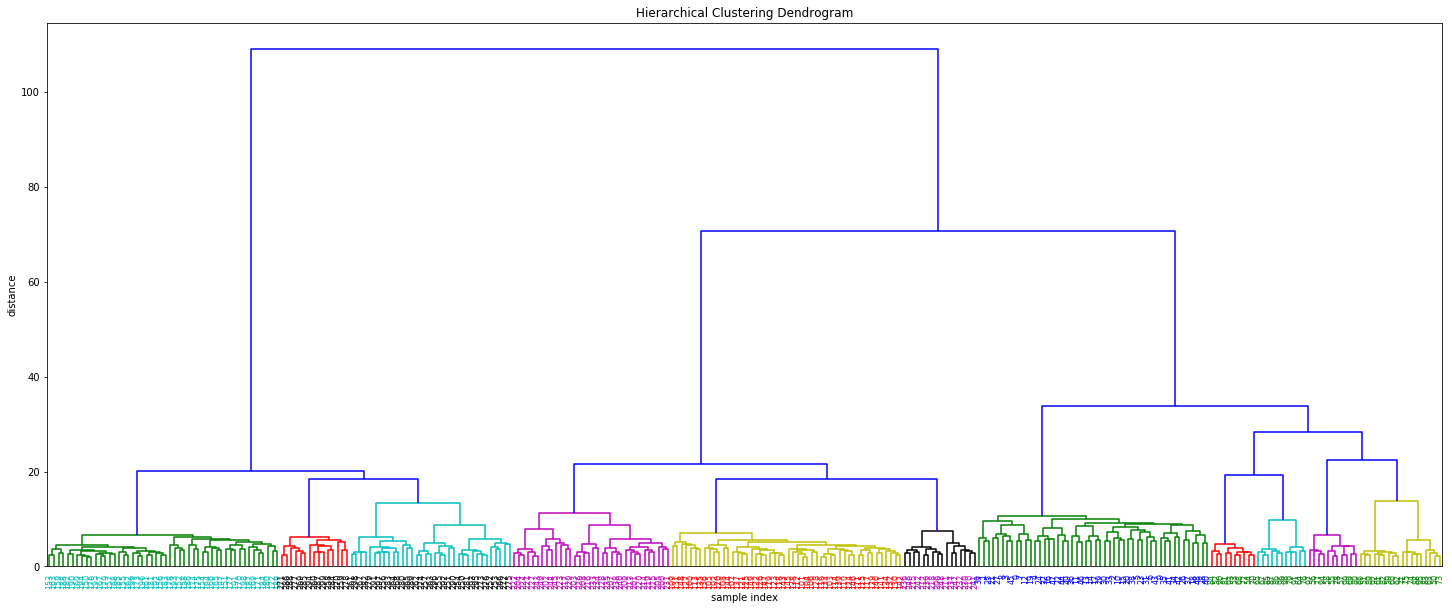

In [48]:
from scipy.spatial.distance import pdist #https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html
from scipy.cluster.hierarchy import linkage #https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html
from scipy.cluster.hierarchy import dendrogram #https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.cluster.hierarchy.dendrogram.html

w=2
dtwdist = lambda u, v: DTWDistance(u, v, w)
DTW = pdist(train, dtwdist)

Z = linkage(DTW, 'ward')

colors = ['b', 'g', 'r', 'c', 'm', 'k']
c = {i: colors[int(val)-1] for i, val in enumerate(train[:,-1])}

plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
    color_threshold=15, # where to start to put distinct colors
)
ax = plt.gca()
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    lbl.set_color(c[int(lbl.get_text())])

plt.show()

# Finish the task (homework)

1. Perform some experiments to obtain an idea on the performance of `DTWDistance` and `LB_Keogh` similarity measures on `test` and `train` data using the provided class information (in the last column). In other words, try to aswer the question if one of the distances could be used for sucessful clustering of `train` and/or for classification of `test`?
1. For each class of `train`, construct its wedge (from the lecture) and use it as the envelope bounds $U$ and $L$ for a redefined `LB_Keogh` distance. Use this distance on the `test` and try to classify its elements and report on the performance of the classification (sucess percentage and confusion matrix).
1. (Optional! Bonus points might be awarded.) Perform a clustering method of your choice on `train` and compare the obtained cluster with the provided class information.

You are allowed to modify and experiment with the two measures!

## Solution

Because LB_Keogh and DTW distance can measure the similarity of two Time series, it is possible to try to use the KNN algorithm, for example, to find the most similar time series and to classify it using its class.

I tried the algorithm below, but the measurement is very slow because the counting of the distance to each sample is very slow and it is not possible to use any of the effective cuts in the KNN algorithms. Therefore, the results from this measurement are somewhat experimental for testing.

It is easy to find that there are six classes in the dataset, so after trying the KNN, I will try to represent each class in the middle. So I use the K-means algorithm.

# 1

In [49]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score

def knn(k, train, test, dist_metric, w, have_class=True):
    predictions=[]
    for to_predict in test:
        nearest=[]
        # compute distances
        for j in train: nearest.append([j[-1], dist_metric(to_predict[:-1],j[:-1],w)])
        # sort
        nearest.sort(key=lambda x: (x[1]), reverse = False)
        # get counts of classes in nearest
        
        so = np.unique([i[0] for i in nearest[0:k]], return_counts=True)
        # get major class
        predictions.append(so[0][np.argmax(so[1])])
    return (test[:,-1], predictions) if have_class else predictions

In [50]:
from sklearn.metrics import confusion_matrix
import itertools
import time

# taken from http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = (cm.max() + cm.min()) / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [51]:
# Load data
train = np.genfromtxt('train.csv', delimiter='\t')
test = np.genfromtxt('test.csv', delimiter='\t')
# classes
class_names = [1, 2, 3, 4, 5, 6] 

Accurancy: 0.8733333333333333
CPU times: user 2min 42s, sys: 252 ms, total: 2min 42s
Wall time: 2min 43s


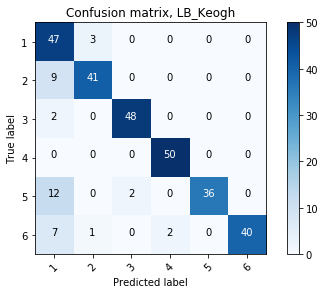

In [52]:
%%time
# Compute confusion matrix LB_Keogh distance
tst, prd = knn(1, train, test, LB_Keogh, 4)
print("Accurancy:", accuracy_score(tst, prd))
cnf_matrix = confusion_matrix(tst, prd)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, LB_Keogh')


Accurancy: 0.99
CPU times: user 19min 35s, sys: 1.17 s, total: 19min 36s
Wall time: 19min 41s


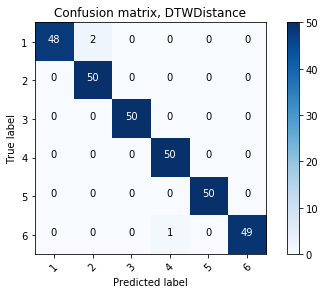

In [53]:
%%time
# Compute confusion matrix DTWDistance
tst, prd = knn(1, train, test, DTWDistance, 4)
print("Accurancy:", accuracy_score(tst, prd))
cnf_matrix = confusion_matrix(tst, prd)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, DTWDistance')

I measured for k equal to 1, according to the nearest neighbor. It can be seen that LB_Keogh produces worse results than DTWDistacne, but also much faster. This holds the assumption that this is a faster option for DTWDistance and holds:

$$ LB Keogh (Q, C) \leq DTW (Q, C) $$

By with this is possible in KNN, where k = 1 computes LB Keogh and if is bigger we can go compute next. 

I will try to apply the same idea to K-means and create centroid. First, I count the centroid positions and then use these centroids to classify.

In [54]:
import random
import copy

def k_means_clust(data, num_clust, num_iter, w, dist_metric):
    centroids = [data[i] for i in random.sample(range(len(data)), num_clust)]
    centroids_old = None
    cnt = 0
    while True:
        cnt += 1
        print("Iter:", cnt)
        centroid_assign = {}
        # assign data points to clusters
        for train_ID, i in enumerate(data):
            min_distance = float('inf')
            closest_cluster = None
            # Find nearest cluster
            for cluster_ID, j in enumerate(centroids):
                # apply accelarition of computed nearest distance
                dist = dist_metric(i, j, w)
                if dist < min_distance:
                    min_distance = dist
                    closest_cluster = cluster_ID
            # assing dat in the nearest cluster
            if closest_cluster in centroid_assign:
                centroid_assign[closest_cluster].append(train_ID)
            else:
                centroid_assign[closest_cluster] = [train_ID]
        
        # recalculate centroids of clusters, as center of the data in cluster
        for cluster_ID in centroid_assign:
            # sum of all values in time series
            cluster_sum = 0
            # calculate sum
            for k in centroid_assign[cluster_ID]:
                cluster_sum = cluster_sum + data[k]
            # centroid as average of all reprezentants of cluster
            if type(cluster_sum) is int:
                centroids[cluster_ID] = centroids[cluster_ID]
            else:       
                centroids[cluster_ID] = [m/len(centroid_assign[cluster_ID]) for m in cluster_sum]
        

        if cnt >= num_iter:
            break
    
    return centroids

#### Now I create the centroids in the training data.

In [55]:
import matplotlib.pylab as plt
train = np.genfromtxt('train.csv', delimiter='\t')
test = np.genfromtxt('test.csv', delimiter='\t')
centroids1=k_means_clust(train[:, :-1],10,20,8, LB_Keogh)
centroids2=k_means_clust(train[:, :-1],10,20,8, DTWDistance)

Iter: 1
Iter: 2
Iter: 3
Iter: 4
Iter: 5
Iter: 6
Iter: 7
Iter: 8
Iter: 9
Iter: 10
Iter: 11
Iter: 12
Iter: 13
Iter: 14
Iter: 15
Iter: 16
Iter: 17
Iter: 18
Iter: 19
Iter: 20
Iter: 1
Iter: 2
Iter: 3
Iter: 4
Iter: 5
Iter: 6
Iter: 7
Iter: 8
Iter: 9
Iter: 10
Iter: 11
Iter: 12
Iter: 13
Iter: 14
Iter: 15
Iter: 16
Iter: 17
Iter: 18
Iter: 19
Iter: 20


#### Find the class of the centroid to classification.

In [56]:
prd1 = knn(1, train, centroids1, DTWDistance, 8, have_class=False)
prd2 = knn(1, train, centroids2, DTWDistance, 8, have_class=False)
print("Class centroids LB_Keogh: ", prd1)
print("Class centroids DTWDistance: ", prd2)
for ind, i in enumerate(centroids1):
    i.append(prd1[ind])
for ind, i in enumerate(centroids2):
    i.append(prd2[ind])

Class centroids LB_Keogh:  [3.0, 5.0, 5.0, 2.0, 5.0, 4.0, 5.0, 5.0, 4.0, 6.0]
Class centroids DTWDistance:  [3.0, 2.0, 6.0, 3.0, 5.0, 5.0, 5.0, 5.0, 4.0, 4.0]


#### Now can use centroids as the train set in knn and try to predict and measure success rate on the test set.

The big advantage of this is that we can compute centers. And in classification, we are fast, because we only find the nearest centroid and classification use this centroid. And the methos is the fastest, but how we can see, there is some problem with classificate the class one. I try find sollution for this, but I cant find centroid for one class. Even if I used a larger amount of centroid, I did not manage to place the centroid in Class 1.

Accurancy: 0.7966666666666666
CPU times: user 51.5 s, sys: 144 ms, total: 51.7 s
Wall time: 51.8 s


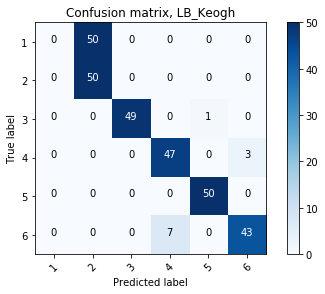

In [57]:
%%time
# Compute confusion matrix DTWDistance
tst, prd = knn(1, centroids1, test, DTWDistance, 8)
print("Accurancy:", accuracy_score(tst, prd))
cnf_matrix = confusion_matrix(tst, prd)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, LB_Keogh')

Accurancy: 0.5866666666666667
CPU times: user 51.5 s, sys: 88 ms, total: 51.6 s
Wall time: 51.7 s


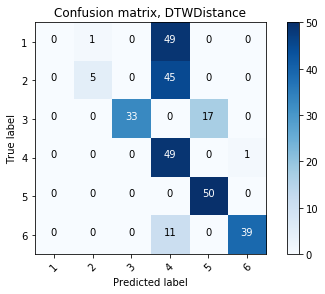

In [58]:
%%time
# Compute confusion matrix DTWDistance
tst, prd = knn(1, centroids2, test, DTWDistance, 8)
print("Accurancy:", accuracy_score(tst, prd))
cnf_matrix = confusion_matrix(tst, prd)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, DTWDistance')

#### Show plot of centroids 

### LB_Keogh

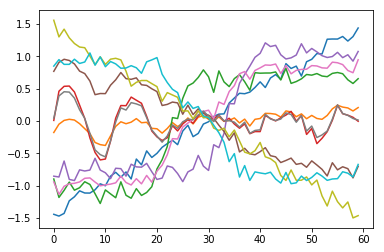

In [59]:
from IPython.display import display, Markdown, Latex
display(Markdown('### LB_Keogh'))
for i in centroids1:
    plt.plot(i[:-1])
plt.show()

### DTWDistance

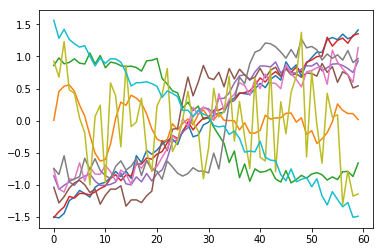

In [60]:
display(Markdown('### DTWDistance'))
for i in centroids2:
    plt.plot(i[:-1])
plt.show()

#### In other words, try to aswer the question if one of the distances could be used for sucessful clustering of train and/or for classification of test?

The answer is **YES**. For classification can be used both. I have tried some tests that have confirmed this. Then I tried to create centroid and cluster. And it is possible to cloud the power of these time series distances. I tried the clustering above and plotted the individual centroids and use for classification and test it and print accuracy. The results are pretty good, for each test I have listed accuracy and confusion matrix. I also drew centroids. But the best results have KNN with DTWDistance.

# 2

#### Change LB Keogh for computing from wedge

In [83]:
def LB_KeoghW(UL,q):
    LB_sum = 0
    for ind, i in enumerate(q):        
        if i > UL[0][ind]:
            LB_sum += (i - UL[0][ind])**2
        elif i < UL[1][ind]:
            LB_sum += (i - UL[1][ind])**2
    return np.sqrt(LB_sum)

In [84]:
train = np.genfromtxt('train.csv', delimiter='\t')
test = np.genfromtxt('test.csv', delimiter='\t')

#### Computing wedge for each class and print example of one

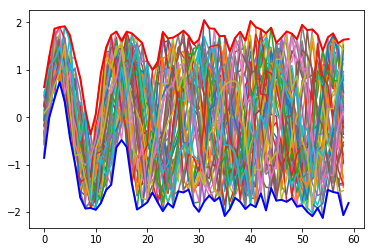

In [85]:
classes = {}
for i in train:
    if i[-1] in classes:
        classes[i[-1]].append(i[:-1])
    else:
        classes[i[-1]] = [i[:-1]]
# Calculate wedges
wedges = {}
for i in classes:
    wedges[i] = [np.max(classes[i], axis=0),np.min(classes[i], axis=0)]
# Print example
maxx = np.max(classes[2], axis=0)
minn = np.min(classes[2], axis=0)
for i in classes[2]:
    plt.plot(i[:-1])
plt.plot(maxx, linewidth=2, color='red')
plt.plot(minn, linewidth=2, color='blue')
plt.show()

#### Change KNN to 1NN for work with wedge, computed nearest 

In [86]:
def knnForWedge(wedge, test):
    predictions=[]
    for to_predict in test:
        nearest=[]
        # compute distances
        for j in wedge: 
            nearest.append([j, LB_KeoghW(wedge[j],to_predict[:-1])])
        # sort
        nearest.sort(key=lambda x: (x[1]), reverse = False)
        predictions.append(nearest[0][0])
    return test[:,-1], predictions

#### Try on test part of data and print accuracy and confusion matrix.

Accurancy: 0.7333333333333333
CPU times: user 912 ms, sys: 148 ms, total: 1.06 s
Wall time: 999 ms


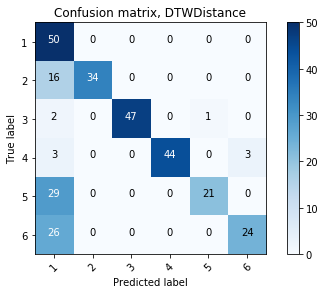

In [87]:
%%time

# Compute confusion matrix DTWDistance
tst, prd = knnForWedge(wedges, test)
print("Accurancy:", accuracy_score(tst, prd))
cnf_matrix = confusion_matrix(tst, prd)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, using Wedge')

I place wedge and use it as an envelope with the boundaries 𝑈 and 𝐿 for the predefined distance LB_Keogh. I try to use this distance for each class to classified. 

As can be seen below, it is the fastest method I've tested, and its results are not the worst. This method, in my tests, looked as successful as k-means with individual metrics or was even better.

The KNN itself was better, but the difference of several minutes and less than one second is enormous.

In all tests, it was obvious that the biggest problem is when classing a class one, which even runs the largest area in the graph when I plotted the boundaries. So, when using wedges, I ranked many time series as 1. On the other hand, K-means did not find a center for this class because the other time series were closer while finding centers.

Overall, experiments are very good, confirming that these metrics can be successfully used to classify and clustering time series.

# 3

Answers and work are under **1**; I perform cluster method K-means, which I measured.